In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, auc, roc_curve, average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
import ast
from imblearn.over_sampling import SMOTE

sns.set()

## Trying a different model for each stage


We will build a model with the best (smallest p values) for each stage

### Helper functions

In [3]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get accuracy
    right = np.diagonal(cm).sum()
    acc = float(right)/cm.sum()
    print("Accuracy is {} %".format(acc*100))
    tpr = float(cm[1,1])/cm[1,:].sum()
    fpr = float(cm[0,1])/cm[0,:].sum()
    precision = float(cm[1,1])/cm[:,1].sum()
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return acc, tpr, fpr, precision

# Data preprocessing

In [4]:
df = pd.read_csv('data/cleaned.csv')

In [311]:
df['tumor_stage'].value_counts()

stage ii     663
stage iii    264
stage i      192
stage iv      21
Name: tumor_stage, dtype: int64

In [ ]:
genes_p_values = pd.read_csv('data/best_genes_per_stage.csv').drop(columns=['Unnamed: 0'])

In [221]:
genes_p_values.head(20)

,1,2,3,4
0,"('ENSG00000021852.11', 0.0)","('ENSG00000068976.12', 0.0)","('ENSG00000022355.13', 0.0)","('ENSG00000002933.6', 0.0)"
1,"('ENSG00000068976.12', 0.0)","('ENSG00000077522.11', 0.0)","('ENSG00000047936.9', 0.0)","('ENSG00000003989.15', 0.0)"
2,"('ENSG00000068985.4', 0.0)","('ENSG00000081248.9', 0.0)","('ENSG00000054796.11', 0.0)","('ENSG00000004777.17', 0.0)"
3,"('ENSG00000075388.3', 0.0)","('ENSG00000089250.17', 0.0)","('ENSG00000054938.14', 0.0)","('ENSG00000006116.3', 0.0)"
4,"('ENSG00000077009.12', 0.0)","('ENSG00000091482.5', 0.0)","('ENSG00000060566.12', 0.0)","('ENSG00000007350.15', 0.0)"
5,"('ENSG00000077522.11', 0.0)","('ENSG00000092054.12', 0.0)","('ENSG00000068985.4', 0.0)","('ENSG00000010282.13', 0.0)"
6,"('ENSG00000081248.9', 0.0)","('ENSG00000101306.9', 0.0)","('ENSG00000075388.3', 0.0)","('ENSG00000010438.15', 0.0)"
7,"('ENSG00000083622.8', 0.0)","('ENSG00000101470.8', 0.0)","('ENSG00000080618.12', 0.0)","('ENSG00000012171.16', 0.0)"
8,"('ENSG00000087128.8', 0.0)","('ENSG00000101892.10', 0.0)","('ENSG00000083622.8', 0.0)","('ENSG00000012504.12', 0.0)"
9,"('ENSG00000091482.5', 0.0)","('ENSG00000104848.1', 0.0)","('ENSG00000091583.9', 0.0)","('ENSG00000012817.14', 0.0)"


In [182]:
def get_genes(r):
    if "nan" in r:
        return None
    t = ast.literal_eval(r)
    return t[0]

def get_pvalue(r):
    if "nan" in r:
        return None
    t = ast.literal_eval(r)
    return t[1]

good_genes_for_1 = genes_p_values['1'].apply(get_genes)
good_genes_for_2 = genes_p_values['2'].apply(get_genes)
good_genes_for_3 = genes_p_values['3'].apply(get_genes)
good_genes_for_4 = genes_p_values['4'].apply(get_genes)

pvalues_for_1 = genes_p_values['1'].apply(get_pvalue)
pvalues_for_2 = genes_p_values['2'].apply(get_pvalue)
pvalues_for_3 = genes_p_values['3'].apply(get_pvalue)
pvalues_for_4 = genes_p_values['4'].apply(get_pvalue)

In [324]:
good_genes_for_1.head(20)

0     ENSG00000021852.11
1     ENSG00000068976.12
2      ENSG00000068985.4
3      ENSG00000075388.3
4     ENSG00000077009.12
5     ENSG00000077522.11
6      ENSG00000081248.9
7      ENSG00000083622.8
8      ENSG00000087128.8
9      ENSG00000091482.5
10    ENSG00000092054.12
11     ENSG00000101306.9
12     ENSG00000101327.7
13     ENSG00000101470.8
14    ENSG00000101892.10
15     ENSG00000103310.9
16     ENSG00000104321.9
17    ENSG00000104760.15
18     ENSG00000104848.1
19     ENSG00000104879.4
Name: 1, dtype: object

(-5, 100)

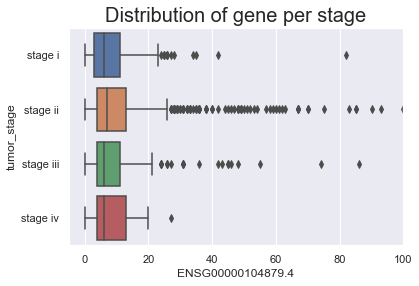

In [336]:
sns.boxplot(y = 'tumor_stage', x = 'ENSG00000104879.4', data = df)
# plt.xlabel('Tumor Stage')
# plt.ylabel('Age')
plt.title('Distribution of gene per stage', fontsize=20);
plt.xlim((-5,100))

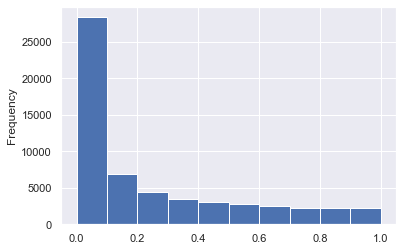

In [185]:
pvalues_for_2.plot(kind='hist')

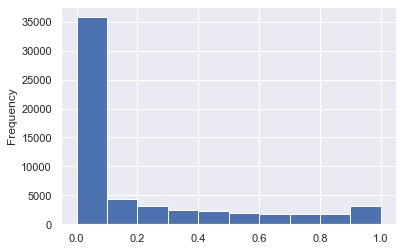

In [186]:
pvalues_for_3.plot(kind='hist')

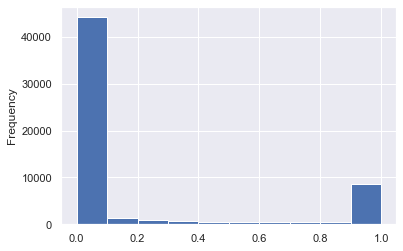

In [187]:
pvalues_for_4.plot(kind='hist')

In [50]:
df['is_stage_1'] = df['tumor_stage'] == 'stage i'
df['is_stage_2'] = df['tumor_stage'] == 'stage ii'
df['is_stage_3'] = df['tumor_stage'] == 'stage iii'
df['is_stage_4'] = df['tumor_stage'] == 'stage iv'

In [318]:
n_of_genes = 300

In [319]:
np.random.seed(2)
test_indices = np.random.choice(df.index, size=200, replace=False)
test_indices

array([ 462,  883,  453,  761,  695,  158,  437,  659,  969,  853,  792,
        476,  599,  618,  549,  525,  690,   61,  399,  777,  557,  781,
        959,  895,  197,   68, 1081,  496,  226,  411, 1128, 1040,  470,
        239,  213, 1026,  498,  439,  590,  483, 1063,  330,  397,  829,
        137,   58,  451,  768, 1022,  280,  486,  351, 1062,  263,  284,
        624,  795,  941,  734,  873,  707,  864,  945,  787,  385,  798,
        414,  750,  715, 1078,  441,  595,  200,  977,  286,  684,  842,
        232,  814, 1001,  272, 1120, 1064,  102,  836,  540,  741,  994,
        809,   67,  999,  315,  322, 1085,  535,  573,  818,  230,  323,
          7, 1106,  546,  376, 1056,  821,  633,  343,  846,   37,  265,
        199,  658,  484,   91,  949,  407,  522,  688,  391,  989,  542,
        979,  993,  169,  834, 1113,  183,  146,  656,  612,  223,  844,
        680,  212,  375,  438, 1018,  418,  919,  672,  851,   60,  580,
        782,  367,  355,    0, 1108,  812,  305,  4

# Stage 1

In [320]:
X = df[list(good_genes_for_1[:n_of_genes])]
y = df['is_stage_1']

X_train, X_test, y_train, y_test = X[~X.index.isin(test_indices)], X[X.index.isin(test_indices)],\
                                        y[~y.index.isin(test_indices)], y[y.index.isin(test_indices)]
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## Modeling

#### Tunning

In [321]:
md_values = range(1, 30, 2)
acc_test = []
acc_train = []
for md in md_values:
    clf = RandomForestClassifier(n_estimators=100, max_depth=md).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(md_values, acc_test, label='test')
plt.plot(md_values, acc_train, label='train')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
n_estimators = range(1, 200, 20)
acc_test = []
acc_train = []
for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=25).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(n_estimators, acc_test, label='test')
plt.plot(n_estimators, acc_train, label='train')
plt.legend()
plt.show()

In [322]:
clf = RandomForestClassifier(n_estimators=75, max_depth=22).fit(X_train, y_train)

y_pred = clf.predict(X_test)

## Results

Accuracy is 78.5 %


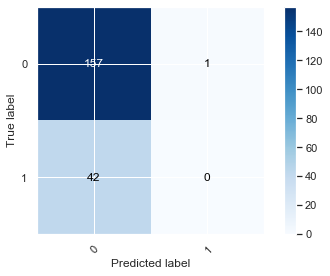

TPR = 0.0, FPR = 0.006329113924050633, Precision = 0.0


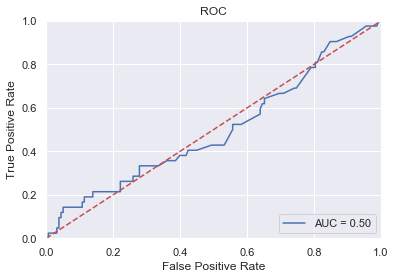

In [323]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [248]:
df['is_stage_1'].value_counts()/df.shape[0]

False    0.831579
True     0.168421
Name: is_stage_1, dtype: float64

## Predict proba

In [249]:
proba_1 = clf.predict_proba(X_test)

# Stage 2

In [255]:
X = df[list(good_genes_for_2[:n_of_genes])]
y = df['is_stage_2']

X_train, X_test, y_train, y_test = X[~X.index.isin(test_indices)], X[X.index.isin(test_indices)],\
                                        y[~y.index.isin(test_indices)], y[y.index.isin(test_indices)]
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## Modeling

#### Tunning

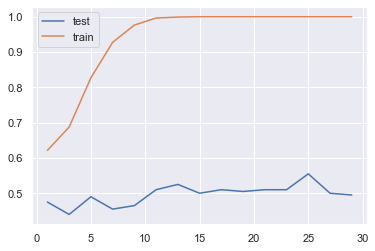

In [251]:
md_values = range(1, 30, 2)
acc_test = []
acc_train = []
for md in md_values:
    clf = RandomForestClassifier(n_estimators=100, max_depth=md).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(md_values, acc_test, label='test')
plt.plot(md_values, acc_train, label='train')
plt.legend()
plt.show()

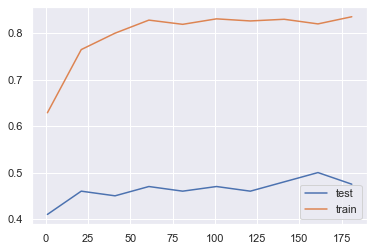

In [257]:
n_estimators = range(1, 200, 20)
acc_test = []
acc_train = []
for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=5).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(n_estimators, acc_test, label='test')
plt.plot(n_estimators, acc_train, label='train')
plt.legend()
plt.show()

In [258]:
clf = RandomForestClassifier(n_estimators=160, max_depth=5).fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Results

Accuracy is 47.5 %


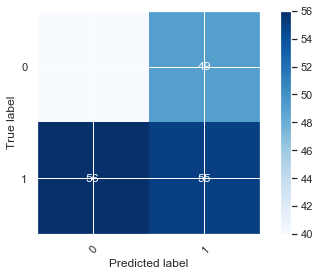

TPR = 0.4954954954954955, FPR = 0.550561797752809, Precision = 0.5288461538461539


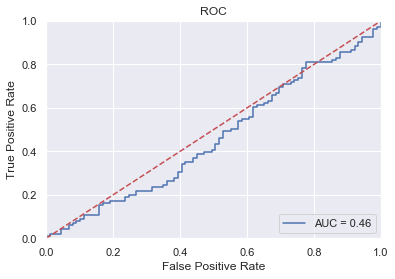

In [259]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Predict proba

In [260]:
proba_2 = clf.predict_proba(X_test)

# Stage 3

In [261]:
X = df[list(good_genes_for_3[:n_of_genes])]
y = df['is_stage_3']

X_train, X_test, y_train, y_test = X[~X.index.isin(test_indices)], X[X.index.isin(test_indices)],\
                                        y[~y.index.isin(test_indices)], y[y.index.isin(test_indices)]
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## Modeling

#### Tunning

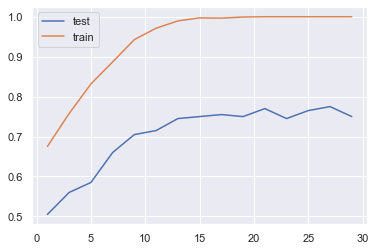

In [262]:
md_values = range(1, 30, 2)
acc_test = []
acc_train = []
for md in md_values:
    clf = RandomForestClassifier(n_estimators=100, max_depth=md).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(md_values, acc_test, label='test')
plt.plot(md_values, acc_train, label='train')
plt.legend()
plt.show()

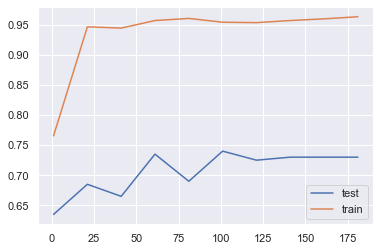

In [263]:
n_estimators = range(1, 200, 20)
acc_test = []
acc_train = []
for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=10).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(n_estimators, acc_test, label='test')
plt.plot(n_estimators, acc_train, label='train')
plt.legend()
plt.show()

In [264]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10).fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Results

Accuracy is 72.0 %


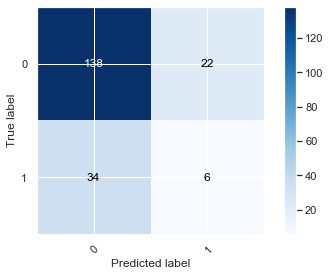

TPR = 0.15, FPR = 0.1375, Precision = 0.21428571428571427


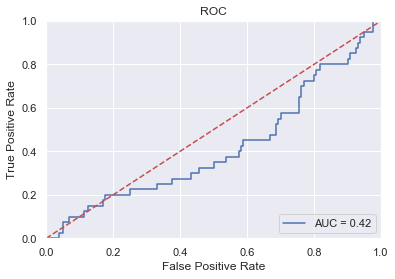

In [265]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Predict proba

In [266]:
proba_3 = clf.predict_proba(X_test)

# Stage 4

In [267]:
X = df[list(good_genes_for_4[:n_of_genes])]
y = df['is_stage_4']

X_train, X_test, y_train, y_test = X[~X.index.isin(test_indices)], X[X.index.isin(test_indices)],\
                                        y[~y.index.isin(test_indices)], y[y.index.isin(test_indices)]
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## Modeling

#### Tunning

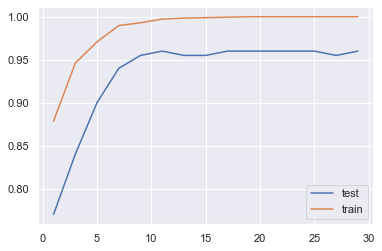

In [268]:
md_values = range(1, 30, 2)
acc_test = []
acc_train = []
for md in md_values:
    clf = RandomForestClassifier(n_estimators=100, max_depth=md).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(md_values, acc_test, label='test')
plt.plot(md_values, acc_train, label='train')
plt.legend()
plt.show()

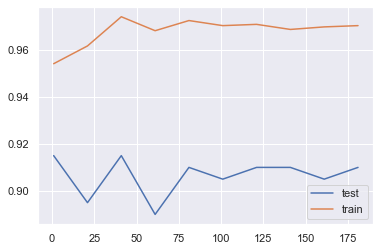

In [269]:
n_estimators = range(1, 200, 20)
acc_test = []
acc_train = []
for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=5).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(n_estimators, acc_test, label='test')
plt.plot(n_estimators, acc_train, label='train')
plt.legend()
plt.show()

In [270]:
clf = RandomForestClassifier(n_estimators=75, max_depth=25).fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Results

Accuracy is 95.5 %


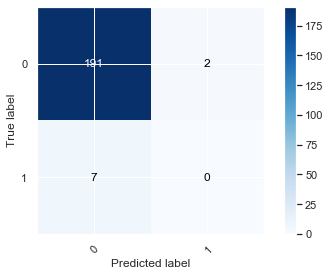

TPR = 0.0, FPR = 0.010362694300518135, Precision = 0.0


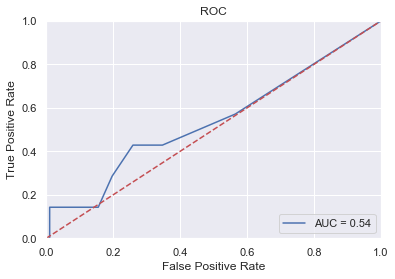

In [271]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Predict proba

In [272]:
proba_4 = clf.predict_proba(X_test)

# Combining results

In [276]:
proba_1.shape

(200, 2)

In [279]:
prob_classes = [[p1[1], p2[1], p3[1], p4[1]] for p1, p2, p3, p4 in zip(proba_1, proba_2, proba_3, proba_4)]

In [282]:
prob_classes

[[0.56, 0.4154098085069096, 0.6039565675442448, 0.04],
 [0.4666666666666667, 0.517937823152376, 0.4174741326004434, 0.0],
 [0.4533333333333333,
  0.34697874014952845,
  0.16071407452947525,
  0.06666666666666667],
 [0.32, 0.4516033905852975, 0.4560691444332637, 0.04],
 [0.14666666666666667,
  0.4135755167514503,
  0.3555803087109939,
  0.013333333333333334],
 [0.4666666666666667, 0.47217089327136763, 0.27437434037248454, 0.0],
 [0.21333333333333335,
  0.5595393165014302,
  0.3726483597432292,
  0.06666666666666667],
 [0.17333333333333334,
  0.6151710090115999,
  0.31371439758657965,
  0.02666666666666667],
 [0.16, 0.44871980366796904, 0.3754442011965511, 0.0],
 [0.44, 0.46477732768562185, 0.41131442575632193, 0.05333333333333334],
 [0.13333333333333333,
  0.566800729907748,
  0.27849176277706744,
  0.30666666666666664],
 [0.25333333333333335, 0.5844007801554174, 0.20574824962557917, 0.0],
 [0.13333333333333333,
  0.5374064387163815,
  0.2385040658321767,
  0.013333333333333334],
 [0.13

In [294]:
y_pred = [np.argmax(row) for row in prob_classes]

In [295]:
y_test = df[df.index.isin(test_indices)]['tumor_stage'].replace({'stage i': 0, 'stage ii': 1, 'stage iii': 2, 'stage iv': 3 })

## Results

Accuracy is 44.5 %


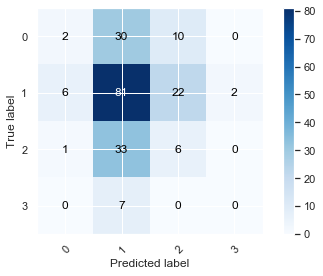

In [299]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()